In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
import math
from sklearn.metrics import accuracy_score

### 1(a) Decision Tree Construction

In [2]:
def get_np_array(file_name, encoding):
    global label_encoder
    data = pd.read_csv(file_name)
    
    need_label_encoding = ['team','opp','host','month', 'day_match']
#     if(label_encoder is None):
    if encoding == "ordinal":
        label_encoder = OrdinalEncoder()
    else:
        label_encoder = OneHotEncoder(sparse_output = False)
    label_encoder.fit(data[need_label_encoding])
    data_1 = pd.DataFrame(label_encoder.transform(data[need_label_encoding]), columns = label_encoder.get_feature_names_out())
    
    #merge the two dataframes
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo" ,"result"]
    data_2 = data[dont_need_label_encoding]
    final_data = pd.concat([data_1, data_2], axis=1)
    
    X = final_data.iloc[:,:-1]
    y = final_data.iloc[:,-1:]
    return X.to_numpy(), y.to_numpy()

file_name_train= "./data/train.csv"
file_name_val= "./data/val.csv"
file_name_test= "./data/test.csv"



In [3]:
import numpy as np
from sklearn.metrics import accuracy_score


count = 0
class TreeNode:
    def __init__(self, depth, max_depth):
        self.depth = depth
        self.max_depth = max_depth
        self.split_attribute = None
        self.split_value = None
        self.is_leaf = False
        self.class_label = None
        self.children = {}
        
def entropy(y):
    ones = np.count_nonzero(y == 1)
    zeros = np.count_nonzero(y == 0)
    total = ones + zeros
    if total == 0:
        return 0
    prob_0 = zeros / total
    prob_1 = ones / total
    if prob_0 in (0, 1) or prob_1 in (0, 1):
        return 0
    ent = -(prob_0 * np.log2(prob_0) + prob_1 * np.log2(prob_1))
    return ent


def entropy_continous_attribute(X, y, attribute, indices_less_median, indices_more_median):
    prob_0 = len(indices_less_median) / len(y)
    prob_1 = len(indices_more_median) / len(y)
    entropy_attribute = prob_0 * entropy(y[indices_less_median]) + prob_1 * entropy(y[indices_more_median])
    
    return entropy_attribute

def entropy_categorical_attribute(X, y, attribute,indices_dict):
    entropy_attribute = 0
    total_values = len(y)

    for key in indices_dict:
        indices = indices_dict[key]
        prob_attr = len(indices) / total_values
        entropy_attribute += prob_attr * entropy(y[indices])

    return entropy_attribute

def split_continuous_attribute(X, y, attribute):
    lis = X[:, attribute].astype(float)
    med = np.median(lis)
    indices_less_median = np.argwhere(lis <= med).flatten()
    indices_more_median = np.argwhere(lis > med).flatten()
    return indices_less_median, indices_more_median

def split_categorical(X, y, attribute):
    unique_values = np.unique(X[:, attribute])
    indices_dict = {}
    for unique_value in unique_values:
        indices = np.where(X[:, attribute] == unique_value)[0]
        indices_dict[unique_value] = indices
    return indices_dict

def fit(X, y,cont_idx, max_depth, depth=0):
    
    unique_classes = np.unique(y)
    
    if depth == max_depth or len(unique_classes) == 1:
        
        node = TreeNode(depth, max_depth)
        node.is_leaf = True
        node.class_label = majority_vote(y)
        return node

    entropy_dataset = entropy(y)
    num_features = X.shape[1]
    best_info_gain = 0
    best_attribute = None
    best_split_value = None

    for attribute in range(num_features):
       
        is_continuous = attribute in cont_idx 
        if is_continuous:
            indices_less_median, indices_more_median = split_continuous_attribute(X, y, attribute)
            info_gain = entropy_dataset-entropy_continous_attribute(X, y, attribute, indices_less_median, indices_more_median)
            
            split_value = np.median(X[:, attribute])
        else:
            indices_dict = split_categorical(X, y, attribute)
            info_gain = entropy_dataset-entropy_categorical_attribute(X, y, attribute, indices_dict)

        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_attribute = attribute
            best_split_value = split_value if is_continuous else None

    if best_info_gain == 0:
        node = TreeNode(depth, max_depth)
        node.is_leaf = True
        node.class_label = majority_vote(y)
        return node

    node = TreeNode(depth, max_depth)
    node.split_attribute = best_attribute
    node.split_value = best_split_value
    node.children = {}

    if best_attribute in cont_idx:  
        indices_less_median, indices_more_median = split_continuous_attribute(X, y, best_attribute)
        node.children[0] = fit(X[indices_less_median], y[indices_less_median], cont_idx,max_depth, depth + 1)
        node.children[1] = fit(X[indices_more_median], y[indices_more_median], cont_idx,max_depth, depth + 1)
    else:
        indices_dict = split_categorical(X, y, best_attribute)
        for key in indices_dict:
            node.children[key] = fit(X[indices_dict[key]], y[indices_dict[key]],cont_idx, max_depth, depth + 1)

    return node



def majority_vote(y):
    unique_elements = np.unique(y)
    max_count = 0
    majority_element = None

    for element in unique_elements:
        count = np.sum(y == element)
        if count > max_count:
            max_count = count
            majority_element = element

    return majority_element


def predict(root, X, cont_idx):
    predictions = []

    for sample in X:
        node = root
        while not node.is_leaf:
            if node.split_attribute in cont_idx: 
                if sample[node.split_attribute] <= node.split_value:
                    node = node.children[0]
                else:
                    node = node.children[1]
            else:
                attribute_value = sample[node.split_attribute]
                if attribute_value in node.children:
                    node = node.children[attribute_value]
                else:
                    predictions.append(majority_vote(sample))
                    break
        predictions.append(node.class_label)

    return predictions






In [4]:

X_train, y_train= get_np_array(file_name_train,encoding="ordinal")
X_val, y_val= get_np_array(file_name_val,encoding="ordinal")
X_test, y_test= get_np_array(file_name_test,encoding="ordinal")

types = ['cat','cat','cat',"cat","cat","cont","cat","cat","cat" ,"cont","cont" ,"cont" ]

max_depths_list= [5,10,15,20,25]
train_acc_list=[]
test_acc_list=[]

continuous_idx = [i for i, val in enumerate(types) if val == 'cont']   


for max_depth in max_depths_list:
    
    decision_tree = fit(X_train, y_train,continuous_idx, max_depth)
    
    
    train_preds= predict(decision_tree,X_train,continuous_idx)
    train_accuracy = accuracy_score(y_train, train_preds)
    
    print(f"Train Accuracy for Maximum depth {max_depth}: {100 * train_accuracy: .2f}%\n")
    train_acc_list.append(train_accuracy)
    
    
    test_preds= predict(decision_tree,X_test,continuous_idx)
    test_preds = [item for item in test_preds if item is not None]
    test_accuracy= accuracy_score(y_test, test_preds)
    
    
    print(f"Test Accuracy for Maximum depth {max_depth}: {100 * test_accuracy: .2f}%\n")
    test_acc_list.append(test_accuracy)

Train Accuracy for Maximum depth 5:  88.57%

Test Accuracy for Maximum depth 5:  57.60%

Train Accuracy for Maximum depth 10:  99.63%

Test Accuracy for Maximum depth 10:  60.29%

Train Accuracy for Maximum depth 15:  99.69%

Test Accuracy for Maximum depth 15:  60.29%

Train Accuracy for Maximum depth 20:  99.69%

Test Accuracy for Maximum depth 20:  60.29%

Train Accuracy for Maximum depth 25:  99.69%

Test Accuracy for Maximum depth 25:  60.29%



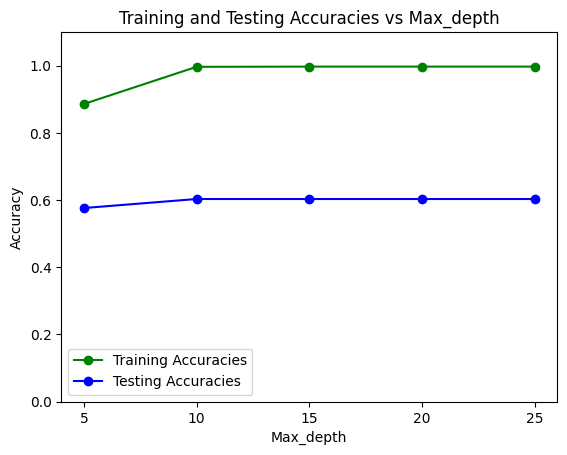

In [5]:
plt.plot(max_depths_list, train_acc_list, marker='o',color='green', label='Training Accuracies')
plt.plot(max_depths_list, test_acc_list, marker='o', color='blue', label='Testing Accuracies')

plt.title('Training and Testing Accuracies vs Max_depth')
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.xticks(max_depths_list)
plt.ylim(0,1.1)
plt.legend()
plt.show()

### 1(b) Decision Tree One Hot Encoding

In [6]:

X_train, y_train= get_np_array(file_name_train,encoding="onehot")
X_val, y_val= get_np_array(file_name_val,encoding="onehot")
X_test, y_test= get_np_array(file_name_test,encoding="onehot")


types = ['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cont', 'cat', 'cat', 'cat', 'cont', 'cont', 'cont']

max_depths_list= [15,25,35,45]
train_acc_list=[]
test_acc_list=[]

continuous_idx = [i for i, val in enumerate(types) if val == 'cont']   


for max_depth in max_depths_list:
    
    decision_tree = fit(X_train, y_train,continuous_idx, max_depth)
    
    
    train_preds= predict(decision_tree,X_train,continuous_idx)
    train_accuracy = accuracy_score(y_train, train_preds)
    
    print(f"Train Accuracy for Maximum depth {max_depth}: {100 * train_accuracy: .2f}%\n")
    train_acc_list.append(train_accuracy)
    
    
    test_preds= predict(decision_tree,X_test,continuous_idx)
    test_accuracy= accuracy_score(y_test, test_preds)
    
    
    print(f"Test Accuracy for Maximum depth {max_depth}: {100 * test_accuracy: .2f}%\n")
    test_acc_list.append(test_accuracy)

Train Accuracy for Maximum depth 15:  70.54%

Test Accuracy for Maximum depth 15:  55.84%

Train Accuracy for Maximum depth 25:  84.82%

Test Accuracy for Maximum depth 25:  61.63%

Train Accuracy for Maximum depth 35:  92.45%

Test Accuracy for Maximum depth 35:  61.32%

Train Accuracy for Maximum depth 45:  99.00%

Test Accuracy for Maximum depth 45:  61.01%



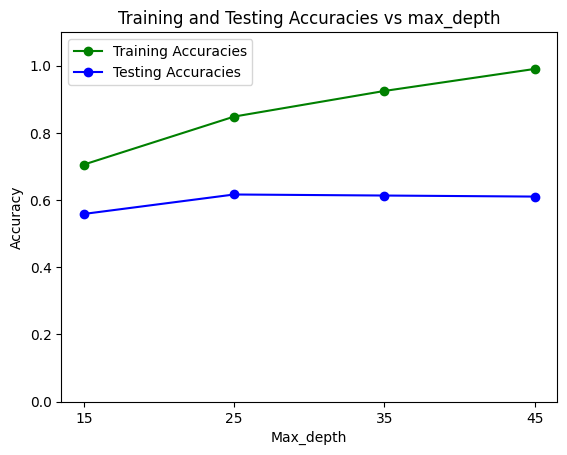

In [7]:
plt.plot(max_depths_list, train_acc_list, marker='o',color='green', label='Training Accuracies')
plt.plot(max_depths_list, test_acc_list, marker='o', color='blue', label='Testing Accuracies')

plt.title('Training and Testing Accuracies vs max_depth')
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.xticks(max_depths_list)
plt.ylim(0,1.1)
plt.legend()
plt.show()

### 1(c) Pruning

### 1(d) Sklearn 


### (i)

In [8]:
Y_train, Y_val,Y_test= y_train, y_val, y_test

In [9]:
accuracy_lists_sk_val=[]
accuracy_lists_sk_train=[]

max_depths_list=[15, 25, 35, 45]

best_clf_d= None
best_acc_val=0.0
for max_depth in max_depths_list:
    clf_d= DecisionTreeClassifier(criterion= 'entropy', max_depth=max_depth)
    clf_d.fit(X_train, Y_train)
    Y_pred_train= clf_d.predict(X_train)
    Y_pred_val= clf_d.predict(X_val)
    accuracy_train = accuracy_score(Y_train, Y_pred_train)
    accuracy_lists_sk_train.append(accuracy_train)
    accuracy_val = accuracy_score(Y_val, Y_pred_val)
    accuracy_lists_sk_val.append(accuracy_val)
    
    if accuracy_val>best_acc_val:
        best_acc_val= accuracy_val
        best_clf_d= clf_d 


In [10]:
print(accuracy_lists_sk_train)
print(accuracy_lists_sk_val)


[0.7135556407308036, 0.8548613772837613, 0.943273284783442, 0.9954005366040629]
[0.5873563218390805, 0.6080459770114942, 0.6333333333333333, 0.6333333333333333]


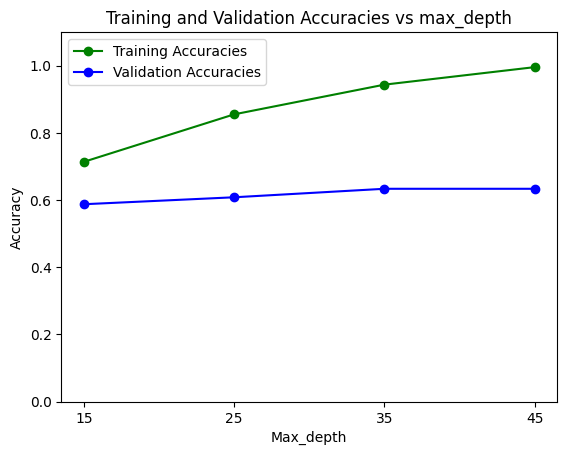

Test Accuracy: 65.14994829369184%


In [11]:
plt.plot(max_depths_list, accuracy_lists_sk_train, marker='o',color='green', label='Training Accuracies')
plt.plot(max_depths_list, accuracy_lists_sk_val, marker='o', color='blue', label='Validation Accuracies')

plt.title('Training and Validation Accuracies vs max_depth')
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.xticks(max_depths_list)
plt.ylim(0,1.1)
plt.legend()
plt.show()


Y_pred_test= best_clf_d.predict(X_test)
accuracy_test= accuracy_score(Y_test, Y_pred_test)
print(f"Test Accuracy: {accuracy_test*100}%")

At depth=45, accuracy is maximum i.e. 62.75%

### (ii)

[0.6894084579021337, 0.5344320940334739, 0.5033857161108982, 0.5033857161108982]
[0.632183908045977, 0.5, 0.4735632183908046, 0.4735632183908046]


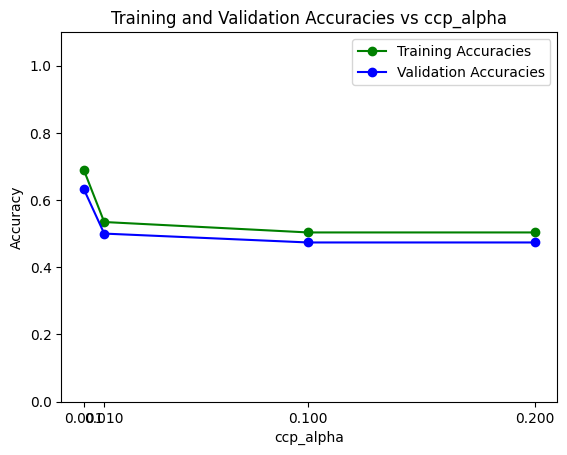

Test Accuracy: 66.28748707342295%


In [12]:
accuracy_lists_train_ccp=[]
accuracy_lists_val_ccp=[]

ccp_alpha_list=[0.001, 0.01,0.1,0.2]

best_clf_d= None
best_acc_val=0.0
for alpha in ccp_alpha_list:
    clf_d= DecisionTreeClassifier(criterion= 'entropy', ccp_alpha=alpha)
    clf_d.fit(X_train, Y_train)
    Y_pred_train= clf_d.predict(X_train)
    Y_pred_val= clf_d.predict(X_val)
    accuracy_train = accuracy_score(Y_train, Y_pred_train)
    accuracy_lists_train_ccp.append(accuracy_train)
    accuracy_val = accuracy_score(Y_val, Y_pred_val)
    accuracy_lists_val_ccp.append(accuracy_val)
    
    if accuracy_val>best_acc_val:
        best_acc_val= accuracy_val
        best_clf_d= clf_d 

print(accuracy_lists_train_ccp)
print(accuracy_lists_val_ccp)

plt.plot(ccp_alpha_list, accuracy_lists_train_ccp, marker='o',color='green', label='Training Accuracies')
plt.plot(ccp_alpha_list, accuracy_lists_val_ccp, marker='o', color='blue', label='Validation Accuracies')

plt.title('Training and Validation Accuracies vs ccp_alpha')
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.xticks(ccp_alpha_list)
plt.ylim(0,1.1)
plt.legend()
plt.show()

Y_pred_test= best_clf_d.predict(X_test)
accuracy_test= accuracy_score(Y_test, Y_pred_test)
print(f"Test Accuracy: {accuracy_test*100}%")

In [ ]:
from sklearn.model_selection import GridSearchCV

### 1(e) Random Forests

#### (i)

In [13]:
def oob_scoring(clf,X,y):
    return clf.oob_score_


param_dict = {"n_estimators":np.arange(start=50, stop=350, step=100),
              "max_features": np.arange(start=0.1, stop=1, step=0.2),
              "min_samples_split": np.arange(start=2, stop=10, step=2)}

rfc = RandomForestClassifier(criterion='entropy', oob_score=True, random_state=42)
clf = GridSearchCV(rfc, param_dict, cv=3, scoring=oob_scoring, n_jobs=-1, verbose=3, refit=True)
clf.fit(X_train, y_train)

NameError: name 'GridSearchCV' is not defined

In [ ]:
best_clf = clf.best_estimator_
best_clf.fit(X_train, y_train)

d:\ProgrammingRelated\AnacondaNavigator\envs\pytorch_gpu\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(criterion='entropy', max_features=0.9000000000000001,
                       min_samples_split=8, n_estimators=250, oob_score=True,
                       random_state=42)

In [ ]:

train_acc = best_clf.score(X_train, y_train)*100
test_acc = best_clf.score(X_test, y_test)*100

print(f"Training Accuracy of best estimator is : {train_acc}")
print(f"Test Accuracy of best estimator is : {test_acc}")
print(f"OOB Score of best estimator is : {best_clf.oob_score_}")

Training Accuracy of best estimator is : 98.96512073591414
Test Accuracy of best estimator is : 72.69906928645294
OOB Score of best estimator is : 0.721732464545803


### 1(f) XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)



In [ ]:
print(f"Accuracy: {100*accuracy}%")


Accuracy: 73.2161323681489%
